# Face Mask Detector using tensorflow and cv

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns

Working directory location

In [2]:
pwd

'C:\\Users\\ishar\\Documents\\MaskDetectorProject'

In [3]:
directory = "C:\\Users\\ishar\\Documents\\MaskDetectorProject\\annotations"
image_directory = "C:\\Users\\ishar\\Documents\\MaskDetectorProject\\images"
df = pd.read_csv("C:\\Users\\ishar\\Documents\\MaskDetectorProject\\Train.csv")

Helper Function to get bounding box data from json file

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

Printing the head of DataFrame df

In [7]:
df = pd.read_csv("Train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,1801.jpg,451,186,895,697,face_no_mask
1,1802.jpg,110,71,273,272,face_with_mask
2,1802.jpg,160,151,268,265,mask_surgical
3,1803.jpg,126,75,303,333,face_with_mask
4,1803.jpg,147,200,288,320,mask_surgical


json files contain the dimensions of bounding box where faces exist and its category i.e., masked or non masked.
Hence, from entire image, only face is cropped and is fed to neural network for training.

In [8]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

Creating a countplot to check number of images which contains mask and non-mask

C:\Users\ishar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

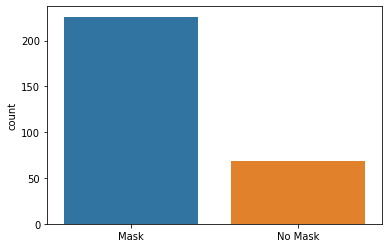

In [9]:
countplot_data = []
for face in data:
    if(face[1] == 0):
        countplot_data.append("Mask")
    else:
        countplot_data.append("No Mask")
sns.countplot(countplot_data)

Feature Scaling and Reshapping input image data

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

Importing Tensorflow and Scikit-Learn libraries

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Creating Model and Adding CONV, Maxpool layers with dropouts

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

Creating Train Test Split and ImageDataGenerator

In [13]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen= ImageDataGenerator(rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

Plotting Random image and random Transformed image

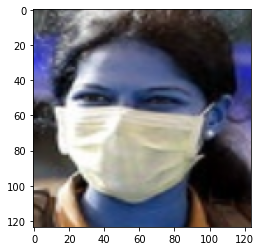

In [15]:
plt.imshow(X[1])

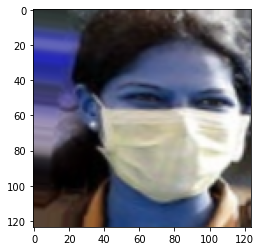

In [18]:
plt.imshow(datagen.random_transform(X[1]))

Fitting the model and running for 50 epochs

In [19]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50
7/7 [==============================] - 31s 4s/step - loss: 1.2813 - accuracy: 0.6652 - val_loss: 0.5945 - val_accuracy: 0.7627
Epoch 2/50
7/7 [==============================] - 28s 4s/step - loss: 0.4640 - accuracy: 0.7833 - val_loss: 0.3622 - val_accuracy: 0.7797
Epoch 3/50
7/7 [==============================] - 27s 4s/step - loss: 0.4170 - accuracy: 0.7882 - val_loss: 0.3153 - val_accuracy: 0.7627
Epoch 4/50
7/7 [==============================] - 25s 4s/step - loss: 0.2966 - accuracy: 0.8177 - val_loss: 0.2591 - val_accuracy: 0.8475
Epoch 5/50
7/7 [==============================] - 25s 4s/step - loss: 0.2760 - accuracy: 0.8719 - val_loss: 0.2788 - val_accuracy: 0.8136
Epoch 6/50
7/7 [==============================] - 27s 4s/step - loss: 0.2572 - accuracy: 0.8473 - val_loss: 0.2338 - val_accuracy: 0.8644
Epoch 7/50
7/7 [==============================] - 27s 4s/step - loss: 0.2680 - accuracy: 0.9212 - val_loss: 0.1975 - val_accuracy: 0.8983
Epoch 8/50
7/7 [==================

Printing Summary of Model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

In [21]:
model.metrics_names

['loss', 'accuracy']

Plotting Graph for loss vs epochs

<AxesSubplot:>

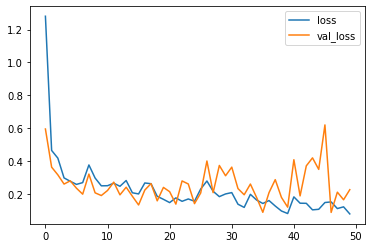

In [22]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

Plotting Graph for accuracy vs epochs

<AxesSubplot:>

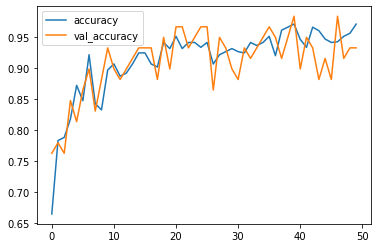

In [23]:
accuracy_plot = pd.DataFrame(model.history.history)
accuracy_plot[['accuracy','val_accuracy']].plot()

Importing prototxt and caffemodel files for face detection using cv

In [24]:
cvNet = cv2.dnn.readNetFromCaffe('deploy.prototxt_1.txt','res10_300x300_ssd_iter_140000 (1).caffemodel')

Testing Random images using SSD and plotting bounding box and predicted labels for all input images.

1/1 [==============================] - 0s 55ms/step


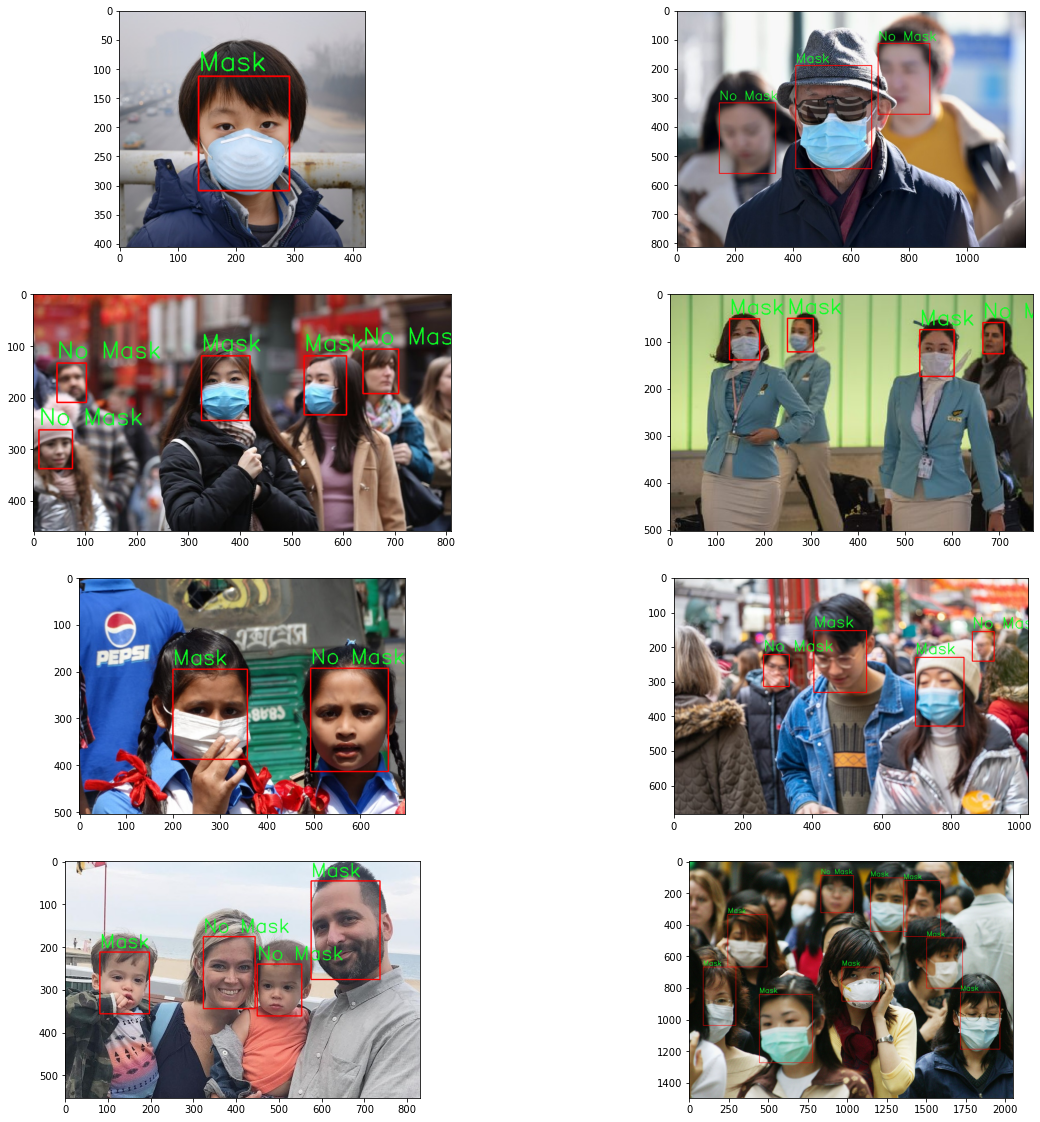

In [26]:
input_shape=(124,124,3)
batch_size=32
test_images = ['1803.jpg','1885.jpg', '0428.jpg','0111.png','1827.jpg','1851.jpg','0517.jpeg','0233.jpg']

gamma = 2.0
fig = plt.figure(figsize = (20,20))
rows = 4
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Predicted Faces with and without mask accurately.

# Thank You